In [1]:
# ML imports
import torch
from torch import optim, cuda
from torchvision import models
import torch.nn as nn
from torchsummary import summary
import gym

from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision import transforms


# normal tools
import numpy as np
import json
from PIL import Image 

# Timing utility
from timeit import default_timer as timer

# Visualizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['font.size'] = 14
import seaborn as sns

In [2]:
# get the selected environments
with open('selected_envs.json', 'r') as f:
    selected_envs = json.load(f)

# set some hyperparameters
batch_size = 1

# Whether to train on a GPU
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
gpu_count = cuda.device_count()
print(gpu_count)

first_gym = selected_envs["training"][0]
print(f'The first gym is {first_gym}')

Train on gpu: True
1
The first gym is Solaris-v4


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


The original observation from the Solaris-v4 Open AI Gym:


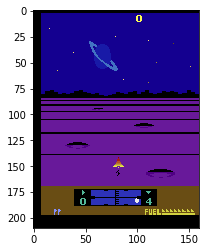

In [3]:
# Visualize original data, and determine what it will look like after preprocessing 
env = gym.make(first_gym)
observation = env.reset()

print("The original observation from the Solaris-v4 Open AI Gym:")
imgplot = plt.imshow(observation)


The observation after greyscale conversion


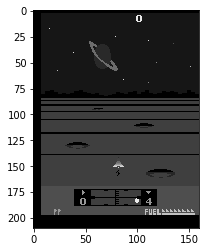

In [4]:
# convert image to grayscale 
bw_obs = Image.fromarray(observation).convert('L')
print("The observation after greyscale conversion")
greyscale_plot = plt.imshow(bw_obs)

Observation after resizing to 114x150


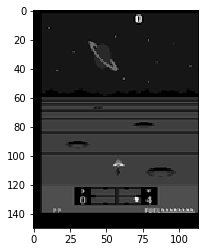

In [5]:
# resize image
new_width = 150
new_height = 114
new_size = new_height, new_width
bw_obs.thumbnail(new_size, Image.ANTIALIAS)

tmp = np.array(bw_obs)
tmp = np.append(tmp, tmp[-1].reshape(1, tmp[-1].shape[0]), axis=0)
bw_obs = Image.fromarray(tmp)

print(f'Observation after resizing to {new_height}x{new_width}')
resized_obs = plt.imshow(bw_obs)

# method for later use:
def preprocess_obs(observation):
    bw_obs = Image.fromarray(observation).convert('L')
    new_width = 150
    new_height = 114
    new_size = new_height, new_width
    bw_obs.thumbnail(new_size, Image.ANTIALIAS)
    tmp = np.array(bw_obs)
    tmp = np.append(tmp, tmp[-1].reshape(1, tmp[-1].shape[0]), axis=0)
    bw_obs = Image.fromarray(tmp)
    return bw_obs


In [6]:
# build a model 

input_size = bw_obs.size
print(input_size)

# However, we will downscale the atari screen to simplify things

class AtariCNN(nn.Module):
    def __init__(self):
        super(AtariCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=3, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            # nn.Conv2d(8, 1, 3, stride=3, padding=1),  # b, 8, 3, 3
            # nn.ReLU(True),
            # nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(1, 8, 3, stride = 3),
            # nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=3, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# learning_rate = 1e-3
model = AtariCNN().cuda() 
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model 

(114, 150)


AtariCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(3, 3), padding=(1, 1))
    (5): Tanh()
  )
)

In [7]:
# Prepare transforms 
trans_to_tensor = transforms.ToTensor()
trans_to_img = transforms.ToPILImage(mode='L')

# tests
# print(bw_obs.size)
# 
# tens_obs = trans_to_tensor(bw_obs)
# 
# print(tens_obs.size())
# 
# did_work = trans_to_img(tens_obs)
# 
# test_obs = plt.imshow(did_work)

# obs = trans_to_tensor(bw_obs)
# 
# obs = obs.unsqueeze(0)
# 
# input = Variable(obs).cuda()
# 
# print(input.size())

In [8]:
summary(model, input_size=(1, 154, 118), batch_size=batch_size, device='cuda')

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 16, 52, 40]             160
              ReLU-2            [1, 16, 52, 40]               0
         MaxPool2d-3            [1, 16, 26, 20]               0
            Conv2d-4               [1, 8, 9, 7]           1,160
              ReLU-5               [1, 8, 9, 7]               0
         MaxPool2d-6               [1, 8, 8, 6]               0
   ConvTranspose2d-7            [1, 16, 17, 13]           1,168
              ReLU-8            [1, 16, 17, 13]               0
   ConvTranspose2d-9             [1, 8, 51, 39]           3,208
             ReLU-10             [1, 8, 51, 39]               0
  ConvTranspose2d-11           [1, 1, 150, 114]              33
             Tanh-12           [1, 1, 150, 114]               0
Total params: 5,729
Trainable params: 5,729
Non-trainable params: 0
-----------------------------------

In [17]:
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 20
done = False


In [21]:
for epoch in range(num_epochs):
    env = gym.make(first_gym)
    observation = env.reset()
    while not done:
        observation, reward, done, info = env.step(env.action_space.sample())
        # observation is the new data
        observation = preprocess_obs(observation)
        obs = trans_to_tensor(observation)
        obs = obs.unsqueeze(0)
        
        input = Variable(obs).cuda() 
        # forward pass 
        output = model(input)
        loss = criterion(output, input)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        tmp = output.cpu().data
        pic = tmp.squeeze(0)
        # pic = trans_to_img(output.cpu().data)
        save_image(pic, './image_{}.png'.format(epoch))

/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/20], loss:0.0132
epoch [2/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [3/20], loss:0.0132
epoch [4/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [5/20], loss:0.0132
epoch [6/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [7/20], loss:0.0132
epoch [8/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [9/20], loss:0.0132
epoch [10/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [11/20], loss:0.0132
epoch [12/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [13/20], loss:0.0132
epoch [14/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [15/20], loss:0.0132
epoch [16/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [17/20], loss:0.0132
epoch [18/20], loss:0.0132


epoch [19/20], loss:0.0132
epoch [20/20], loss:0.0132


/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jtyo/Apps/anaconda3/envs/RLAgents/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
